# Generative Adversarial Model in Keras with MNIST data

## 1. it is a learning note of the original post [MNIST Generative Adversaial Model in Keras](https://oshearesearch.com/index.php/2016/07/01/mnist-generative-adversarial-model-in-keras/) - all credits are for original writers.
## 2. Original GAN Paper - [Generative Advesarial Networks](http://arxiv.org/abs/1406.2661)
## 3. [Ipython Notebook Demostration](https://github.com/osh/KerasGAN)

## What is GAN
- ___A Generative Model___ to generate target outputs from nothing (e.g., pure random noise).
- ___An Adversarial Model___ trained to distringuish a real output (e.g., from nature) and a generated output (from generative model).
- Two models stacked together to be trained in a competative way, so that performances of both are improved.

## Generative Model
- Generate MNIST images from 100 random numbers
- Model structure:
    - Map random inputs to 200*14*14 feature map
    - Upsample it to desired target size, i.e., 28*28
    - Then apply a series of conv filters (to make it locally smooth?).
    - The final layer is `sigmoid` to make the image between 0 ~ 1
    - BatchNormalization is used across to speed up the convergence

In [1]:
import os
# make it explict and simple to test
os.environ['KERAS_BACKEND'] = 'theano' 
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from IPython import display

%matplotlib inline

In [2]:
from keras.models import Model, Sequential
import keras.backend as K
from keras.layers import Input, BatchNormalization, Flatten
from keras.layers import UpSampling2D, Conv2D, Dropout, Convolution2D
from keras.layers import Reshape, Activation, Dense, LeakyReLU
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.datasets import mnist
from sklearn.utils import shuffle

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is enabled with initial size: 10.0% of memory, cuDNN 5103)


Need to explicitly spell out axis=1 in new version of BatchNormalization in Keras. See [discussions](https://github.com/fchollet/keras/issues/3888). BatchNorm is very important to the performance

In [3]:
nch = 200
g_input = Input(shape=[100])
H = Dense(nch*14*14, init='glorot_normal')(g_input)
H = BatchNormalization(mode=2, axis=1)(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(nch/2, 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2, axis=1)(H)
H = Activation('relu')(H)
H = Convolution2D(nch/4, 3, 3, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode=2, axis=1)(H)
H = Activation('relu')(H)
H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform')(H)
g_V = Activation('sigmoid')(H)
generative_model = Model(input=g_input, output=g_V)
generative_model.compile(loss='binary_crossentropy', optimizer='adam')

## Adversarial Model
- Generally it can be anything that does good job on classifying real and faked images
- Use a simple CNN for this purpose

In [4]:
dropout_rate=0.25
d_input = Input(shape=(1, 28, 28))
H = Convolution2D(256, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(1,activation='sigmoid')(H)
adversarial_model = Model(d_input,d_V)
adversarial_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5))

## Generative Adversarial Network Model as a Stack

In [5]:
def toggle_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [6]:
toggle_trainable(adversarial_model, False)

gan_input = Input(shape = (100,))
h = generative_model(gan_input)
gan_output = adversarial_model(h)

# adversarial_model.trainable = False
# for layer in adversarial_model.layers:
#     layer.trainable = False
    
gan_model = Model(input = gan_input, output = gan_output)
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=5e-4))

# adversarial_model.trainable = True
# for layer in adversarial_model.layers:
#     layer.trainable = True



## pretrain the adversarial model
Quoted from original post
```
We pre-train the discriminative model by generating a handful of random images using the untrained generative model, concatenating them with an equal number of real images of digits, labeling them appropriately, and then fitting until we reach a relatively stable loss value which takes 1 epoch over 20,000 examples.  This is an important step which should not be skipped — pre-training accelerates the GAN massively and I was not able to achieve convergence without it (possibly due to impatience).
```

In [7]:
nb_samples = 10000

In [8]:
## load real images from mnist data
(train_x, train_y), (test_x, test_y) = mnist.load_data()
print train_x.shape, test_x.shape
print train_y.shape, test_y.shape
real_images = np.concatenate([train_x, test_x], axis=0)
real_images = np.expand_dims(real_images, axis = 1).astype(np.float32)
real_images = real_images / 255.
i = np.random.randint(0, real_images.shape[0], nb_samples)
#real_images = real_images[:nb_samples]
real_images = real_images[i,...]
print real_images.shape
print real_images.min(), real_images.max()

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)
(10000, 1, 28, 28)
0.0 1.0


In [9]:
## generate faked images from untrained generative model
seeds = np.random.uniform(0, 1, (nb_samples, 100))
faked_images = generative_model.predict(seeds)
print faked_images.shape
print faked_images.min(), faked_images.max()

(10000, 1, 28, 28)
0.00484466 0.985062


In [10]:
## generate train data
x = np.concatenate([real_images, faked_images], axis=0)
# real images - 1, faked images - 0
y = np.repeat([1, 0], nb_samples).astype(np.float32)
#y = to_categorical(y)
y = y.reshape((-1, 1))
# randomly shuffle the data
x, y = shuffle(x, y)
print x.shape, y.shape

(20000, 1, 28, 28) (20000, 1)


In [11]:
import random

img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print np.min(X_train), np.max(X_train)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


ntrain = 10000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generative_model.predict(noise_gen)
x = np.concatenate((XT, generated_images))
n = XT.shape[0]
# y = np.zeros([2*n,2])
# y[:n,1] = 1
# y[n:,0] = 1
y = np.repeat([1, 0], n)

# make_trainable(discriminator,True)
# discriminator.fit(X,y, nb_epoch=1, batch_size=128)

0.0 1.0
('X_train shape:', (60000, 1, 28, 28))
(60000, 'train samples')
(10000, 'test samples')


In [12]:
## pretrain adversarial model
toggle_trainable(adversarial_model, True)

adversarial_model.fit(x, y, nb_epoch=1,
                      batch_size=128)

Epoch 1/1
20000/20000 [==============================] - 16s - loss: 0.1784    


In [13]:
## check pretrained adversarial model
yhat = adversarial_model.predict(x)
print "accuracy:", np.mean( (yhat[:, 0] > 0.5) == y )
#print "accuracy:", np.mean( np.argmax(yhat) == np.argmax(y) )

accuracy: 1.0


## training of GAN
Typically, it involves iterations of 3 main steps,

1. Generate images by generative_model
2. Train(update) adversarial_model by new generated images and real ones
3. Update GAN (with adversarial frozen) with NOISE and REAL_IMAGE_LABELS

To do so, we need to make the adversarial_model trainable during its own update and non_trainable when used within GAN. This can be done by setting the layers (or model's) traiable parameter to False. I am still puzzled by the usage of it, so will stick with the old way - excplitly turning off and on trainable parameters every time. See [#3881](https://github.com/fchollet/keras/issues/3881) for details

In [14]:
## helper functions

def toggle_trainable(model, trainable):
    model.trainable = trainable
    for l in model.layers:
        l.trainable = trainable
        

def real_image_generator(size=64):
    (train_x, train_y), (test_x, test_y) = mnist.load_data()
    real_images = np.concatenate([train_x, test_x], axis=0)
    real_images = np.expand_dims(real_images, axis = 1).astype(np.float32)
    real_images = real_images / 255.
    N = real_images.shape[0]
    while True:
        i = np.random.randint(0, N, size)
        yield real_images[i,...]
        
def noise_generator(size=64):
    while True:
        seeds = np.random.uniform(0, 1, size=(size, 100)).astype(np.float32)
        yield seeds
        
def fake_image_generator(size=64):
    noise = noise_generator(size)
    while True:
        seeds = noise.next()
        fake_images = generative_model.predict(seeds)
        yield fake_images
        
def make_adversarial_data(real_images, faked_images):
    images = np.concatenate([real_images, faked_images], axis=0)
    labels = np.ones(images.shape[0])
    labels[real_images.shape[0]:] = 0
    labels = labels.reshape((-1, 1)).astype(np.float32)
    #labels = to_categorical(labels)
    images, labels = shuffle(images, labels)
    return images, labels

def make_gan_data(noise):
    labels = np.ones(noise.shape[0]).astype(np.float32)
    #labels = to_categorical(labels)
    labels = labels.reshape((-1, 1))
    noise, labels = shuffle(noise, labels)
    return noise, labels

In [15]:
## test gan trainable
noise = noise_generator(32).next()
x, y = make_gan_data(noise)
#y = np.zeros_like(y)

#toggle_trainable(adversarial_model, False)
gan_model.fit(x, y, nb_epoch=3)

Epoch 1/3
32/32 [==============================] - 0s - loss: 5.9684
Epoch 2/3
32/32 [==============================] - 0s - loss: 0.2840
Epoch 3/3
32/32 [==============================] - 0s - loss: 0.0275


In [16]:
## test real_image generator
reals = real_image_generator().next()
assert reals.shape == (64, 1, 28, 28)
assert np.all(reals >= 0.) and np.all(reals <= 1.0)

## test fake_image generator
fakes = fake_image_generator().next()
assert fakes.shape == (64, 1, 28, 28)
assert np.all(fakes >= 0.) and np.all(fakes <= 1.0)

## test make_adversarial_data
imgs, labls = make_adversarial_data(reals, fakes)
assert imgs.shape == (128, 1, 28, 28)
assert labls.shape == (128, 1)
assert np.all((labls == 0) | (labls == 1))

## test make_gae_data
noise = noise_generator().next()
noise, labls = make_gan_data(noise)
assert noise.shape == (64, 100)
assert labls.shape == (64, 1)
assert np.all(labls == 1) # fake it as real

In [17]:
gan_logs, adversarial_logs = [], []

def plot_loss(losses):
    plt.figure(figsize=(4, 4))
    for name, values in losses.items():
        plt.plot(values, label = name)
    plt.legend(loc="best")
    plt.show()
    
def plot_generated():
    noise = np.random.uniform(0,1,size=[9,100])
    generated_images = generative_model.predict(noise)
    
    fig, axes = plt.subplots(3, 3, figsize=(3, 3))
    axes = axes.ravel()
    for ax, img in zip(axes, generated_images):
        ax.imshow(img[0, :, :], cmap = plt.cm.gray)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

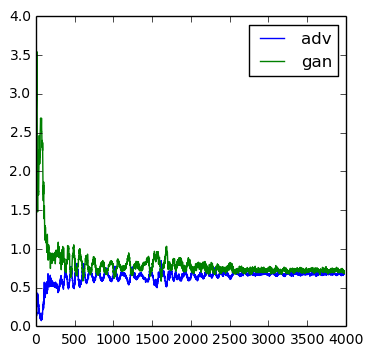

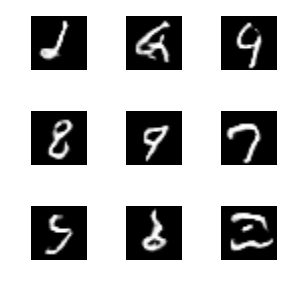

100%|██████████| 1000/1000 [05:24<00:00,  3.62it/s]


In [21]:


nb_epoch = 1000
batch_size = 64

g_real_images = real_image_generator(size=batch_size)
g_fake_images = fake_image_generator(size=batch_size)
g_noise = noise_generator(size=batch_size)

for i in tqdm.tqdm(range(nb_epoch)):
    
    # train adversarial_model
    
    #toggle_trainable(adversarial_model, True)
    real_images = g_real_images.next()
    fake_images = g_fake_images.next()
    x, y = make_adversarial_data(real_images, fake_images)
    
    a_loss = adversarial_model.train_on_batch(x, y)
    adversarial_logs.append(a_loss)
    
    # train GAN
    #toggle_trainable(adversarial_model, False)
    noise = g_noise.next()
    x, y = make_gan_data(noise)
    
    g_loss = gan_model.train_on_batch(x, y)
    gan_logs.append(g_loss)
    
    if i % 25 == 0:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plot_loss({"gan": gan_logs
                  , "adv": adversarial_logs})
        plot_generated()

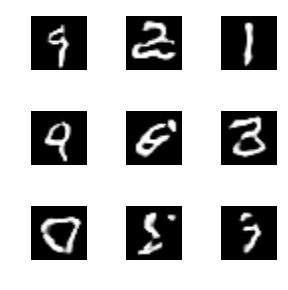

In [26]:
plot_generated()

What does it mean that the two curves converge ... Concidence? Saturated (not necessarily mean good results)?

## Some Observations:
1. Never overfit the adversarial model, because it seems that once it is overfitted, it will be very hard for generative model to learn anything on new cases - the gradient won't propagate? 
2. It is important to pick a balance between the learning rates between the generative and adverserial models. e.g.,
    - if generative is not learning as fast as adversrial, its error will increase a lot, speically at the beginning, which heavily decrease the convergence rate (or never converge at all)
    - if adversirial learning rate is too slow, it might be fooled easily by the generative model, which terminates the learning early and generates unsatisactory results 